In [1]:
%pylab 
from nugridpy import nugridse as mp
from nugridpy import mesa as ms
import matplotlib.pyplot as plt
import itertools
import copy
import os
import scipy.optimize as opt

# use h5py to read and write h5 file
import h5py

data_dir="/data/nugrid_apod2"    

ms.set_nugrid_path(data_dir)
mp.set_nugrid_path(data_dir)

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
# (read in original data)
star = ms.star_log(mass=2.0,Z=0.02)

nugrid_path = /data/nugrid_apod2
closest set is set1.2 (Z = 0.02)
closest mass is 2.0
Using old star.logsa file ...
 reading ...100% 



<IPython.core.display.Javascript object>


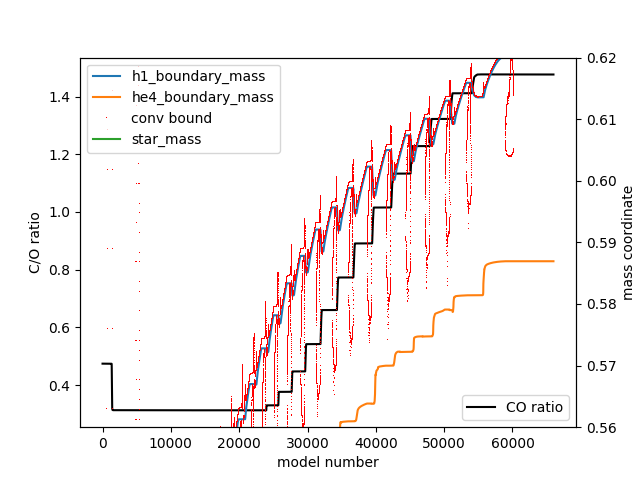

(0.56, 0.62)

In [3]:
# kippenhahn diagram for the thermal pulse of interest
plt.figure(1)
star.kippenhahn_CO(1,'model')

# set limits
# plt.xlim([33000,35000])
plt.ylim([0.56,0.62])

## Prepare File I/O and star_log Arrays

THIS IS AN OLD SETUP, LEAVING JUST IN CASE IT WILL BE USED LATER

In [6]:
# # get the convection boundaries model numbers (restart at 33500, end 34250 (maybe earlier but change data to then))
# cycle_start = 33500
# cycle_end = 34250
# cycle_split = 34000

# # cycle strings
# cycle_strings = []

# # cycle template string
# cycle_template = 'cycle{:>010d}'

# # path to the files to be modified
# path_h5 = '/user/ast501/dstephens/mppnp/diffusion_changes/h5_changes/'

# # h5 file strings
# file_string = [path_h5 + 'M2.00Z0.020.0033001.se.h5',path_h5 + 'M2.00Z0.020.0034001.se.h5']

# ##################################################################
# # SINCE THESE ARE OVER TWO DIFFERENT SE FILES, MARK AND SPLIT WHERE THIS OCCURS
# cycles = []

# # loop over all models FOR FIRST FILE
# for i in range(1 + cycle_split - cycle_start):
#     cycle_strings.append(cycle_template.format(cycle_start + i))

# # have the list within another list
# cycles.append(cycle_strings)
# cycle_strings = []

# # loop over all models FOR SECOND FILE
# for i in range(cycle_end - cycle_split):
#     cycle_strings.append(cycle_template.format(cycle_split + 1 + i))

# cycles.append(cycle_strings)

# # slice arg (need to read appropriate index for each model number being written)
# s_arg1 = [(cycle_start - 1), cycle_split]
# s_arg2 = [cycle_split,cycle_end]

# # get the star_log arrays and slice to appropriate 
# star_mass = [star.get('star_mass')[s_arg1[0]:s_arg1[1]], star.get('star_mass')[s_arg2[0]:s_arg2[1]]]

# # get mix mass coordinates
# mix_bot = [star.get('mx2_bot')[s_arg1[0]:s_arg1[1]] * star_mass[0],
#            star.get('mx2_bot')[s_arg2[0]:s_arg2[1]] * star_mass[1]]
             
# mix_top = [star.get('mx2_top')[s_arg1[0]:s_arg1[1]] * star_mass[0],
#            star.get('mx2_top')[s_arg2[0]:s_arg2[1]] * star_mass[1]]
  
# # this is used to make sure diffusion coefficient doesn't extend this far (it's boundary of operation)
# mix_Hshell = [star.get('mx1_bot')[s_arg1[0]:s_arg1[1]] * star_mass[0],
#              star.get('mx1_bot')[s_arg2[0]:s_arg2[1]] * star_mass[1]]          

In [7]:
# get the convection boundaries model numbers (restart at 33500, end 34250 (maybe earlier but change data to then))
cycle_start = 53001
cycle_end = 53900

# cycle strings
cycle_strings = []

# cycle template string
cycle_template = 'cycle{:>010d}'

# path to the files to be modified
path_h5 = '/user/ast501/dstephens/mppnp/diffusion_changes/h5_changes/diffusion_jones/'

# h5 file strings
file_string = [path_h5 + 'M2.00Z0.020.0053001.se.h5']

##################################################################
cycles = []

# loop over all models FOR FIRST FILE
for i in range(1 + cycle_end - cycle_start):
    cycle_strings.append(cycle_template.format(cycle_start + i))

# have the list within another list
cycles.append(cycle_strings)

# slice arg (need to read appropriate index for each model number being written)
s_arg1 = [(cycle_start - 1), cycle_end]


# get the star_log arrays and slice to appropriate 
star_mass = [star.get('star_mass')[s_arg1[0]:s_arg1[1]]]

# get mix mass coordinates
mix_bot = [star.get('mx2_bot')[s_arg1[0]:s_arg1[1]] * star_mass[0]]

mix_top = [star.get('mx2_top')[s_arg1[0]:s_arg1[1]] * star_mass[0]]
  
# this is used to make sure diffusion coefficient doesn't extend this far (it's boundary of operation)
mix_Hshell = [star.get('mx1_bot')[s_arg1[0]:s_arg1[1]] * star_mass[0]]

## Constants (SI)

In [8]:
Msun = 1.989e30
Rsun = 6.957e8

alpha = 1.6
fcbm_low = 0.015
fcbm_high = 0.03

## Functions

All functions will assume that the arrays have been inverted such that r[0] = 0!

### Boundary Functions

In [9]:
def schwarz(mix_bot,mix_top,mix_Hshell,mass):
    
    # find the elements corresponding to the schwarzschild boundary
    schwarz_bounds = [np.argmin(abs(mass - mix_bot)),np.argmin(abs(mass - mix_top))]
    hshell_bounds = np.argmin(abs(mass - mix_Hshell))
    
    return schwarz_bounds, hshell_bounds

def r0(schwarz_bounds,pressure,radius,fcbm_high,fcbm_low):
    
    # P and R are total sized arrays, use schwarz bounds to get the scale height there
    P_low = pressure[schwarz_bounds[0]:(schwarz_bounds[0]+2)]
    R_low = radius[schwarz_bounds[0]:(schwarz_bounds[0]+2)]
    scale_low = scale_height(P_low,R_low)
    
    P_high = pressure[schwarz_bounds[1]:(schwarz_bounds[1]+2)]
    R_high = radius[schwarz_bounds[1]:(schwarz_bounds[1]+2)]
    scale_high = scale_height(P_high,R_high)
    
    # get the values of r0
    r0_lower = radius[schwarz_bounds[0]] + fcbm_low * scale_low
    r0_upper = radius[schwarz_bounds[1]] - fcbm_high * scale_high
    
    # find the indices that these occur at
    r0_bounds = [np.argmin(abs(r0_lower - radius)),np.argmin(abs(r0_upper-radius))]
    
    # make sure indices make sense (not at schwarzschild or outside of it!)
    if r0_bounds[0] <= schwarz_bounds[0]:
        
        # set r0 to just inside convection zone
        r0_bounds[0] = schwarz_bounds[0] + 1
        
    if r0_bounds[1] >= schwarz_bounds[1]:
        
        # set r0 to just inside convection zone
        r0_bounds[1] = schwarz_bounds[1] - 1
        
    # return bounds and lower scale height (used for vmlt)
    return r0_bounds, scale_low

def diffusion_bounds(schwarz_bounds, hshell_bounds, diffusion):
    
    # the diffusion bounds should be in the vicinity of the schwarz bounds
    # but must be careful not to tread too far to the H-shell convection
    diff_bounds = []
    
    # look for the lower boundary, choose to start from schwarz bounds and go down
    counter = 0
    
    while diffusion[schwarz_bounds[0] - counter] > 1:
        counter += 1
    
    # store the lower boundary
    diff_bounds.append(schwarz_bounds[0] - counter)
    
    # look for the upper boundary
    counter = 0
    flag = 1
    
    while flag:
        
        # keep iterating
        if diffusion[schwarz_bounds[1] + counter] > 1:

            # make sure we haven't gone into the next shell
            if (schwarz_bounds[1] + counter) >= hshell_bounds:

                # not good, for now get a print statement and set it to 10 indices past (arbitrary)
                print('WARNING: diffusion_bounds has iterated to the Hshell')
                
                # make sure you can exit loop
                flag = 0
                
                # make sure 10 isn't too far back
                if schwarz_bounds[1] + 10 >= hshell_bounds:
                    counter = 4
                else:
                    counter = 10

            else:
                counter += 1
        
        # set flag to zero
        else:
            flag = 0
    
    # store the upper boundary
    diff_bounds.append(schwarz_bounds[1] + counter)
    
    # return
    return diff_bounds

### Quantity Functions

In [10]:
def scale_height(pressure,radius):
    
    # this should a 2 len array so the scale height corresponds to itself at point R[0]
    return - np.power(np.diff(pressure) / np.diff(radius),-1) * pressure[0]

def vmlt(r0_bounds,diffusion,alpha,Hp0):
    
    # slice the diffusion array and get vmlt across the stable zone
    v_mlt = 3 * diffusion[r0_bounds[0]:(r0_bounds[1]+1)] / (alpha * Hp0)
    
    # return vmlt
    return v_mlt

def DRCMD(radius,r0_bounds,function_number,v_mlt,alpha,Hp0,scale,mass):
    # function number will tell me which diffusion function to call, some require
    # a scaling factor so that is included as well
    
    # this function will return an array of values which is the modified diffusion coefficient
    # slice the radius array
    radius_D = radius[r0_bounds[0]:(r0_bounds[1]+1)]
    radius_r0_low = radius[r0_bounds[0]]
    radius_r0_high = radius[r0_bounds[1]]
    mass_D = mass[r0_bounds[0]:(r0_bounds[1]+1)]
    
    diffusion = []
    
    # set all variables that need to be defined to 1 for NOW, change depending on function_number
    diffusion_midpoint = 1
    diffusion_bounds = [1,1]
    mass_bounds = [1,1]

    # r -rsc needs to be symmetric about the mid radius point, get median point
    med_radius = np.median(radius_D)
    med_index = np.argmin(abs(med_radius - radius_D))

    # check which function I'm going to use
    if function_number == 1:
        # get the diffusion mid_point 
        diffusion_midpoint = scale * (1/3.) * v_mlt[med_index] * alpha * Hp0
        
    elif function_number == 2:
        # get the diffusion mid_point
        diffusion_midpoint = scale * (1/3.) * v_mlt[med_index] * alpha * Hp0
        
        # get the diffusion at the boundaries and scale down according to scale
        diffusion_bounds[0] = (scale * (1/3.) * v_mlt[0] * alpha * Hp0)
        diffusion_bounds[1] = (scale * (1/3.) * v_mlt[-1] * alpha * Hp0)
        
        # get the mass at the bounds
        mass_bounds[0] = mass[r0_bounds[0]]
        
    # loop over all radii
    for i in range(len(radius_D)):
        
        # r -rsc needs to be symmetric about the mid radius point
        if i < med_index:           
            # get mass bounds for linear fit
            if function_number == 2:
                mass_bounds[0] = mass_D[0]
                mass_bounds[1] = mass_D[med_index]
                
#             diffusion.append(v_mlt[i] * min(alpha * Hp0, abs(radius_D[i] - radius_r0_low)))
            diffusion.append(d_choose(function_number,v_mlt[i],alpha,Hp0,radius_D[i],radius_r0_low,scale,diffusion_midpoint,diffusion_bounds[0],mass_bounds,mass_D[i],left=1))
        else:
            # get mass bounds for linear fit
            if function_number == 2:
                mass_bounds[0] = mass_D[med_index]
                mass_bounds[1] = mass_D[-1]
                
#             diffusion.append(v_mlt[i] * min(alpha * Hp0, abs(radius_D[i] - radius_r0_high)))
            diffusion.append(d_choose(function_number,v_mlt[i],alpha,Hp0,radius_D[i],radius_r0_high,scale,diffusion_midpoint,diffusion_bounds[1],mass_bounds,mass_D[i],left=0))   
    # return
    return diffusion

def overshoot(D0,r0,r,fcbm,Hp):
    
    # Hp is at r0 as well! (NOT at bottom of schwarzschild), this is the convective overshoot
    return D0 * np.exp(- 2 * abs(r - r0) / (fcbm * Hp))

## Diffusion Change Function

These are functions that will change the behaviour of the diffusion coefficient. Some test cases are to scale down the jones functionality, boxcar across the convection boundaries, and a polynomial (linear most likely) fit from the central point to the r0_bounds which is scaled down by some amount from the original.

In [11]:
def d_choose(function_number,vmlt,alpha,Hp0,radius_D,radius_r0,scale,diffusion_midpoint,diffusion_bounds,mass_bounds,mass,left):

    # based on what function number is, run a particular function
    if function_number == 0:
        return d_jones_scale(vmlt,alpha,Hp0,radius_D,radius_r0,scale)
    
    elif function_number == 1:
        return d_boxcar(diffusion_midpoint)
    
    elif function_number == 2:
        # get the linear fit, depending on left side or right. mass bounds always [1] is later
        if left:
            slope = (diffusion_midpoint - diffusion_bounds) / (mass_bounds[1] - mass_bounds[0])
            intercept = diffusion_midpoint - slope * mass_bounds[1]
        else:
            slope = (diffusion_bounds - diffusion_midpoint) / (mass_bounds[1] - mass_bounds[0])
            intercept = diffusion_bounds - slope * mass_bounds[1]
            
        return d_linear(slope,intercept,mass)
    
# jones diffusion and scaling
def d_jones_scale(vmlt,alpha,Hp0,radius_D,radius_r0,scale=1):
    return vmlt * scale * min(alpha * Hp0, abs(radius_D - radius_r0))

# boxcar diffusion
def d_boxcar(diffusion_midpoint):
    return diffusion_midpoint

# linear fit between
def d_linear(slope,intercept,mass):
    return slope * mass + intercept

## Change Diffusion Coefficient

In [ ]:
# bool on whether to convert the SE H5 files or just read through them
convert = 1

############
#
# SET DIFFUSION FUNCTION NUMBER
#
############
function_number = 0

# write a text file saying that it has been changed, else remove if there is a file
if convert:
    
    # create a file
    txt = open(path_h5 + 'DIFFUSION_CHANGE','w')
    txt.write('Diffusion coefficient has been changed')
    txt.close()
    
else:
    
    if os.path.isfile(path_h5 + 'DIFFUSION_CHANGE'):
        
        # delete file
        os.remove(path_h5 + 'DIFFUSION_CHANGE')
        
# BOOL FOR STORING DATA
store_data = 1

# store some values for debugging
model_change = []
mass_backup = []
diff_backup = []
schwarz_backup = []
mix_backup = []

mass_diff_change = []
diff_diff_change = []
temperature_mix = []

# BOOL FOR SUBTIME STEPPING
subtime = 0

# SUBTIME STEP PARAMETERS
subtime_steps = 10
subtime_counter = 0
subtime_number_of_files = int(np.ceil(subtime_steps * (cycle_end + 1 - cycle_start) / 1000.))
subtime_prefix = path_h5 + 'subtime/M2.00Z0.020.00'

# get reading in file names
subtime_h5_files_str = '{:0}001.se.h5'
subtime_h5_files = []
for i in range(subtime_number_of_files):
    subtime_h5_files.append(subtime_prefix + subtime_h5_files_str.format(i + 53))
    
# writing to cycle numbers
subtime_cycle_strings = []
for i in range((1 + cycle_end - cycle_start)*10):
    subtime_cycle_strings.append(cycle_template.format(cycle_start + i))
    
# loop through all files (split into 2)
for i in range(len(cycles)):
    
    # close previous file
    if i != 0:
        data_file.close()
        
    # open the h5 file
    data_file = h5py.File(file_string[i])
    
    # loop through all cycles
    for p in range(len(cycles[i])):
        
        # FIRST determine if the model even has the convection zone AND IF NO SUBTIME STEPPING
        if mix_bot[i][p] <= 1e-9:
            
            # there is no diffusion coefficient to change, exit
            temperature_mix.append(0)
        
            # check if sub time stepping
#             if subtime:
                    
#                 # convert diffusion
# #                 diffusion[diff_bounds[0]:(diff_bounds[1] + 1)] = new_diffusion
                
#                 # NEED ALL QUANTITIES FROM EARLIER DATA TO OVERWRITE, get size as well
#                 data_fields = data_file[cycles[i][p]]['SE_DATASET'].dtype.names
#                 data_size = data_file[cycles[i][p]]['SE_DATASET'].size
                
#                 # for each step, keep same physical parameters but change the time step
#                 subtime_file = h5py.File(subtime_h5_files[0],'r+')
              
#                 # get the time value data_file
#                 time_change = data_file[cycles[i][p]].attrs.get('deltat') / 10.

#                 # get temperature at first value
                
#                 for j in range(subtime_steps):
                        
#                     # modify the correct cycle 
# #                     subtime_file[subtime_cycle_strings[subtime_counter*subtime_steps + j]]['SE_DATASET']['dcoeff'] = np.flip(diffusion,0)
#                     subtime_file[subtime_cycle_strings[subtime_counter*subtime_steps + j]].attrs.modify('deltat',time_change)
#                     subtime_size =  subtime_file[subtime_cycle_strings[subtime_counter*subtime_steps + j]]['SE_DATASET'].size
        
#                     # make sure the size of subtime is the same as the data
#                     if subtime_size != data_size:
#                         subtime_file[subtime_cycle_strings[subtime_counter*subtime_steps + j]]['SE_DATASET'].resize(data_size,0)
#                         print(p,j)
                        
#                     # for every data_field, change
#                     for k in range(len(data_fields)):
#                         subtime_file[subtime_cycle_strings[subtime_counter*subtime_steps + j]]['SE_DATASET'][data_fields[k]] = data_file[cycles[i][p]]['SE_DATASET'][data_fields[k]]
                        
                        
#                 # increment subtime counter
#                 subtime_counter += 1
                
#                 # close file
#                 subtime_file.close()
                
#         # if looking at the last few models, there are bugs of some sort in which the diffusion coefficient 
#         # extends beyond the schwarzschild boundary(perhaps ledoux, depends on how the mx2* were calculated)
#         # and so there is diffusion out there. The deviations of changes of diffusion become significant by the 
#         # time the cycles[i][p] are p >= 180. This is a temporary measure, shouldn't be a big deal though
#         elif i == 1 and p >= 180:

#             # there is no diffusion coefficient to change, exit
#             temperature_mix.append(0)
#             continue
            
        else:
                
            # store the INDEX NUMBER
            if i == 0:
                model_change.append(cycle_start - 1 + p)
            else:
                model_change.append(cycle_split + p)

            # grab the needed data (pressure, radius, mass, diffusion) Radius is in cm?
            # MAKE DEEP COPIES, so nothing changes in the original data
            diffusion = np.flip(data_file[cycles[i][p]]['SE_DATASET']['dcoeff'],0)
            mass = np.flip(data_file[cycles[i][p]]['SE_DATASET']['mass'],0)
            radius = np.flip(data_file[cycles[i][p]]['SE_DATASET']['radius'],0) 
            pressure = np.flip(data_file[cycles[i][p]]['SE_DATASET']['pressure'],0)
            temperature = np.flip(data_file[cycles[i][p]]['SE_DATASET']['temperature'],0)
            
            # store some values for analysis (DEEP COPIES)
            if store_data:
                mass_backup.append(np.copy(mass))
                diff_backup.append(np.copy(diffusion))
            
            # determine the schwarzschild boundaryand hshell limit
            schwarz_bounds, hshell_bounds = schwarz(mix_bot[i][p],mix_top[i][p],mix_Hshell[i][p],mass)

            # determine the r0 boundaries
            r0_bounds, Hp0 = r0(schwarz_bounds,pressure,radius,fcbm_high,fcbm_low)
            
            # get the diffusion boundaries
            diff_bounds = diffusion_bounds(schwarz_bounds,hshell_bounds,diffusion)
            
            # get the v_mlt array all the way to the overshoot limit
            v_mlt = vmlt(r0_bounds,diffusion,alpha,Hp0)
            
            #####################################################################
            #
            # MODIFY DIFFUSION
            #
            #####################################################################
            
            # DIFFUSION CHANGES DEPEND ON function_number!!!!!!!!!!
            # first get within the r0 boundaries
            
            # set up if statements depending on function_number
            if function_number == 0:
                # this is jones with a scale
                scale = 1.
                diffusion_rcmd = DRCMD(radius,r0_bounds,function_number,v_mlt,alpha,Hp0,scale,mass)
                
            elif function_number == 1:
                # this is boxcar, need midpoint of diffusion (solved in DRCMD)
                scale = 1.
                diffusion_rcmd = DRCMD(radius,r0_bounds,function_number,v_mlt,alpha,Hp0,scale,mass)
                
            elif function_number == 2:
                # this is linear, need midpoint of diffusion and diffusion at r0 bounds
                # also need to send in the mass array to get values of diffusion inbetween and a scale
                scale = 1/100.
                diffusion_rcmd = DRCMD(radius,r0_bounds,function_number,v_mlt,alpha,Hp0,scale,mass)
                
            # get the r0's
            r0_lower = radius[r0_bounds[0]]
            r0_upper = radius[r0_bounds[1]]
            
            # get the radii for overshoot
            radius_low = radius[diff_bounds[0]:r0_bounds[0]]
            radius_high = radius[(r0_bounds[1] + 1):(diff_bounds[1]+1)]
            
            # get the scale heights at the r0 boundaries
            P_low = pressure[r0_bounds[0]:(r0_bounds[0]+2)]
            R_low = radius[r0_bounds[0]:(r0_bounds[0]+2)]
            
            Hp_low = scale_height(P_low,R_low)
            
            P_high = pressure[r0_bounds[1]:(r0_bounds[1]+2)]
            R_high = pressure[r0_bounds[1]:(r0_bounds[1]+2)]
            
            Hp_high = scale_height(P_high,R_high)
            
            # get the overshoot in the lower bounds
            diffusion_lower = overshoot(diffusion_rcmd[0],r0_lower,radius_low,fcbm_low,Hp_low)
            diffusion_upper = overshoot(diffusion_rcmd[-1],r0_upper,radius_high,fcbm_high,Hp_high)
            
            # stitch together
            new_diffusion = list(itertools.chain(diffusion_lower,diffusion_rcmd,diffusion_upper))
            
            # change the original diffusion
            diffusion_slice = diffusion[diff_bounds[0]:(diff_bounds[1]+1)]
            mass_slice = mass[diff_bounds[0]:(diff_bounds[1]+1)]
            
            # check if the conversion is being done,
            if convert:
                
#                 # check if it is i == 0, p last
#                 if i == 0 and p == len(cycles[i]) - 1:
                    
#                     # need to hold the diffusion changes, these need to be applied to file 34001 on model
#                     # number 34000 and MUST BE DEEPCOPIES
#                     temp_diff_bounds = copy.deepcopy(diff_bounds)
#                     temp_new_diffusion = copy.deepcopy(new_diffusion)
                    
#                 # check if it is i ==1 and p == 0
#                 elif i == 1 and p == 0:
                    
#                     # need to rewrite 34000
#                     temp_diffusion = np.flip(data_file[cycles[0][-1]]['SE_DATASET']['dcoeff'],0)
#                     temp_diffusion[temp_diff_bounds[0]:(temp_diff_bounds[1]+1)] = temp_new_diffusion
                    
#                     # actually rewrite
#                     data_file[cycles[0][-1]]['SE_DATASET']['dcoeff'] = np.flip(temp_diffusion,0)
                
                # convert diffusion
                diffusion[diff_bounds[0]:(diff_bounds[1] + 1)] = new_diffusion

                # re flip it so that it matches original data structure
                data_file[cycles[i][p]]['SE_DATASET']['dcoeff'] = np.flip(diffusion,0)
                
            # store these values for analysis
            if store_data:
                
                # get mass and diffusion changes
                mass_diff_change.append(copy.deepcopy(mass_slice))
                diff_diff_change.append(copy.deepcopy(new_diffusion))
                
                # get the schwarzschild boundaries and the mixing
                schwarz_backup.append(copy.deepcopy(schwarz_bounds))
                mix_backup.append([mix_bot[i][p],mix_top[i][p]])
                
                temperature_mix.append(temperature[schwarz_bounds[0]])

# Everything has been done, close file
data_file.close()

## Analysis on Data Obtained

Make a check to make sure the data was not only overwritten, but correctly by checking it against a false model.

The diffusion coefficient varies from the mesa model as the schwarzschild boundary is not what is constraining the boundaries of it as seen in the example below

In [ ]:
print(mix_backup[-1])
print(schwarz_backup[-1])
print(star.get('conv_mx2_top')[model_change[-1] ] * star.get('star_mass')[model_change[-1] ])
print(star.get('conv_mx2_bot')[model_change[-1] ] * star.get('star_mass')[model_change[-1] ])
# print mass_backup[-1][schwarz_backup[-1][0]]

In [ ]:
# re open the h5 file
h5_file = h5py.File(file_string[0])

# find where the last model is, and make the string for cycle
cycle_model_end = 'cycle00000' + str(model_change[-1] + 1)

modified_diffusion_h5 = np.flip(h5_file[cycle_model_end]['SE_DATASET']['dcoeff'],0)
mass_h5 = np.flip(h5_file[cycle_model_end]['SE_DATASET']['mass'],0)

In [ ]:
# make plot of last diffusion coefficient found
index = -100
plt.figure(5)
plt.plot(mass_backup[index],np.log10(diff_backup[index]),label='Mesa D')
plt.plot(mass_diff_change[index],np.log10(diff_diff_change[index]),label='Jones D')
plt.plot(mass_h5,np.log10(modified_diffusion_h5),label='h5 diffusion data')
plt.xlim([0.596,0.616])

# labels
plt.xlabel('Mass (M$_\odot$)')
plt.ylabel('log D / cm$^{2}$ s$^{-1}$')

plt.legend()

# close file
h5_file.close()

In [ ]:
# look at the temperature at the minimum step time
time = 10**(star.get('log_dt')) * 365.25
model_number = star.get('model_number')
L_He = star.get('log_LHe')
        
# slice arrays
model_number = model_number[(cycle_start-1):cycle_end]
time = time[(cycle_start-1):cycle_end]
L_He = L_He[(cycle_start-1):cycle_end]

In [ ]:
# plot log years and temp vs model
fig = plt.figure(7)
ax1 = fig.add_subplot(111)

# plot log years
ax1.plot(model_number,np.log10(time),label='log years')
ax1.set_xlabel('model number')
ax1.set_ylabel('log years')

ax2 = ax1.twinx()

ax2.plot(model_number,np.log10(temperature_mix),'r--',label='T at lower Schwarz')
ax2.set_ylabel('log T at lower Schwarz')


In [ ]:
# plot log years and temp vs model
fig = plt.figure(8)
ax1 = fig.add_subplot(111)

# plot log years
ax1.plot(model_number,np.log10(time))

ax2 = ax1.twinx()

ax2.plot(model_number,L_He,'r--')
ax2.set_ylabel('')